# Financial Time Series forecasting using BCVAR (Bayesian Compressed Vector Autoregression) on currency time series

## Description

This project is based on https://github.com/korobilis/BCVAR and the paper: https://ieeexplore.ieee.org/document/8626099. In this notebook we implemented the code for BCVAR written in Matlab (github link), and we do a few changes to perform forecastings.

## Implementation

In [1]:
#Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.matlib as matlib
import glob, os
from numpy import linalg as LA
from scipy import sparse
from scipy.linalg import cholesky

#Augmented dickey fuller test library
from statsmodels.tsa.stattools import adfuller

## First part, getting data from the sources

Based on the paper, we downloaded all the data from Yahoo finance, we used the following link: https://query1.finance.yahoo.com/v7/finance/download/#Currency#=X?period1=1517961600&period2=1533168000&interval=1d&events=history&includeAdjustedClose=true to donwload the files, just by changing the #Currency# part for the currency pair that we were interested in, for example, for currency pair AUD-CAD, we replace the value as follows: https://query1.finance.yahoo.com/v7/finance/download/AUDCAD=X?period1=1517961600&period2=1533168000&interval=1d&events=history&includeAdjustedClose=true.

We did that for the following 27 currency pairs:

AUD-CAD, AUD-CHF, AUD-JPY, AUD-NZD, CAD-CHF, CAD-JPY, CHF-JPY, CHF-TRY, EUR-AUD, EUR-CAD, EUR-CHF, EUR-CZK, EUR-DKK, EUR-GBP, EUR-HKD, EUR-HUF, EUR-ILS, EUR-JPY, EUR-MXN, EUR-NOK, EUR-NZD, EUR-PLN, EUR-RON, EUR-RUB, EUR-SEK, EUR-SGD, EUR-TRY

There were 3 currency pairs mentioned in the document that were not found in Yahoo finance, so, we downloaded those from the following links:

* BGN-RON: https://www.marketwatch.com/investing/currency/bgnron/download-data?startDate=2/7/2018&endDate=8/2/2018
* CHF-BGN: https://www.marketwatch.com/investing/currency/chfbgn/download-data?startDate=2/7/2018&endDate=8/2/2018
* CHF-RON: https://www.marketwatch.com/investing/currency/chfron/download-data?startDate=2/7/2018&endDate=8/2/2018


## Second part, BCVAR implementation
***

Large Vector Autoregression models (VARs) might have multiple parameters that vastly exceed the number of observations. What BCVAR (Bayesian Compressed VAR) does is randomly compressed the exploratory variable to turn a huge dimensional problem into a much smaller one.
<br><br>
General VAR model looks like this:
$$
\begin{equation}
Y_{y} = BY_{t-p} + \epsilon_{t}
\end{equation}
$$
Where:

* $\bf B$: VAR parameters
* $\bf Y_{t-p}$: Predictors in VAR
* $\bf \epsilon_{t}$: Residuals in VAR
<br><br>

BCVAR can be written as follows:

\begin{equation}
Y_t = B^c(\Phi Y_{t-1} + \epsilon_t)
\tag{1}
\end{equation}

<br><br>
Where:

* $\Phi$: Random projection matrix. Is a matrix of $m \times k$, $k = n \times p + 1$ when intercept is included, or $k = n \times p$ if no intercept. With $m << k$.
* $B^c$: compact VAR parameters after compression
* $Y_{t-1} = \Phi Y_{t-1}$ with the dimensiones of $m \times T$, T is the number of predictors in the original VAR model

### Data transformations

There are few transformations that we can apply to the data to make it stationary, below we rewrite in python the 'transxf.m' file from the github repository.

In [2]:
#Do nothing, leave the data as is
def levelT(y, x, n):
    y[:] = x.to_numpy()

#First difference: x(t)-x(t-1)
def firstDiffT(y, x, n):
    y[1:] = x.diff().dropna().to_numpy()

#Second difference: (x(t)-x(t-1))-(x(t-1)-x(t-2))
def secondDiffT(y, x, n):
    y[2:] = x[2:n].to_numpy()-2*(x[1:n-1].to_numpy())+x[0:n-2].to_numpy()

#Natural log: ln(x)
def naturalLogT(y, x, n):
    #Value close to zero 
    small=1e-6;
    
    if min(x) > small:
        y[:] = np.log(x.to_numpy())

#First difference of natural log: ln(x)-ln(x-1)
def firstDiffLogT(y, x, n):
    #Value close to zero 
    small=1e-6;
    if min(x) > small:
        x = np.log(x.to_numpy())
        y[1:] = 100*(x[1:n] - x[0:n-1])

#Second difference of natural log: (ln(x)-ln(x-1))-(ln(x-1)-ln(x-2))
def secondDiffLogT(y, x, n):
    #Value close to zero 
    small=1e-6;
    if min(x) > small:
        x = np.log(x.to_numpy())
        y[2:] = 100*(x[2:n] - 2*(x[1:n-1]) + x[0:n-2])

#First difference of percent change: (x(t)/x(t-1)-1)-(x(t-1)/x(t-2)-1)
def firstDiffPercT(y, x, n):
    x = x.to_numpy()
    x_p = (x[1:n] - x[0:n-1])/x[0:n-1]
    y[2:] = x_p[1:n] - x_p[0:n-2]
    
#This is the function to call all the transformations depending on the parameter in the file
#Data: data to be transformed to be stationary
#tcode: transformation code
def transformData(Data, tcode):
    #Number of observations (rows)
    [n, ]= Data.shape
        
    
    # Allocate output variable
    y = np.array([None] * n);
    
    # Selecting the proper transformation #
    switcher = {
           1: levelT,
           2: firstDiffT,
           3: secondDiffT,
           4: naturalLogT,
           5: firstDiffLogT,
           6: secondDiffLogT,
           7: firstDiffPercT
        
    }
       
    func = switcher.get(tcode, "nothing")
       
    func(y, Data, n)
    
    return y
    

In [3]:
#Function to standardize the data
def standardize(y):
    [T,M] = np.shape(y)
    
    mean = np.mean(y, axis = 0)
    std = np.std(y, axis = 0)
    
    my = matlib.repmat(mean, T, 1)
    sy = matlib.repmat(std, T, 1)
    
    x = (y - my)/sy
    
    return x, mean, std

In [4]:
#Function to add lags to the current data
def mlag2(X,lags):
    
    [rows, columns] = X.shape
    
    Xlag = np.zeros((rows, columns * lags))

    for i in range(0,lags):
        
        Xlag[lags:rows , columns*i: columns * (i + 1)] = X[lags - i -1 : rows - i -1, 0:columns]
    
    return Xlag

$\Phi$ is a matrix of $m \times k$, $k = n \times p + 1$ when intercept is included, or $k = n \times p$ if no intercept. With $m << k$.
<br><br>
For this particular case (compressed VAR) the value $m \sim U[1 , 5ln(k_i)]$
<br><br>
$m$: number of predictors after the compression

### BCVAR coding

In [5]:
def getBCR_priors(M, N):
    #Priors for BCR: Bayesian Compressed Regression
    #model size, n_m1 is the max and n_m2 is the min
    #m: number of rows per random matrix
    
    n_m1 = 5*round(np.log(N)); #Is the max value for the U distribution of m paramater described in the equation
    n_m2 = 1; ##Is the min value for the U distribution of m paramater described in the equation
    
    #
    V_beta = 10 * np.eye(n_m1 + 2)
    iV_beta = 1/10 * np.eye(n_m1 + 2)
    
    v_prior = M
    S_prior = np.eye(M)
    
    return n_m1, n_m2, V_beta, iV_beta, v_prior, S_prior

As we mentioned before, $\Phi$ is a random projection matrix. Using the method from Guhaniyogi and Dunson (2015) -G+Dunson- we can obtain the elements from the matrix.
The elements $ij$ from $\Phi$, where $i = 1,..., m$ and $j = 1,...,k$, are obtained from the following distribution:
<br><br>

\begin{equation}
PR \left(\Phi_{ij} = \frac {1}{\sqrt{\varphi}} \right) = \varphi^2 \\
PR \left(\Phi_{ij} = 0 \right) = 2 (1 - \varphi) \varphi \\
PR \left(\Phi_{ij} = -\frac {1}{\sqrt{\varphi}} \right) = (1 - \varphi)^2
\tag{2}
\end{equation}

<br><br>
We simulate $\Phi$ form uniform distribution $U[a,b]$ where a is close to 0. For $m$ we simulate it from discrete distribution $U[2log(k), min(T,k)]$

<br><br>
$\varphi \sim [0.1, 0.8]$
<br><br>
$\varphi$: elements in random projection matrix

In [6]:
#Functions to get the random projection matrix using the above formula (2)
def genPhi_G_Dunson(m_l, KM):
    
    #Getting a random value from uniform distribution from 0.1 to 0.8
    psi = np.random.uniform(0.1, 0.8)
    
    prob = np.empty((3,1))
    PHI_val = np.empty((3,1))
    
    #Right side of equations above
    prob[0, 0] = psi ** 2
    prob[1, 0] = 2 * (1 - psi) * psi
    prob[2, 0] = (1 - psi) ** 2
    
    #Left side of the equations above
    PHI_val[0, 0] = -np.sqrt(1 / psi)
    PHI_val[1, 0] = 0
    PHI_val[2, 0] = np.sqrt(1 / psi)
    
    #probablities cumulative sum (last row always should be 1)
    cum_prob = np.cumsum(prob,0)
    #Generating a random number between 0 and 1 in a matrix m_1 x KM (compressed dimension and original dimention)
    PHI = np.random.rand(m_l,KM)
    #We compare if the random value is between zero and the first cumulative sum
    GG = (PHI <= cum_prob[0,0])
    #We compare if the random value is between first cumulative sum and the second cumulative sum
    GG2 = ( (PHI <= cum_prob[1,0]) & (PHI > cum_prob[0,0]) )
    #We compare if the random value is between the second cumulative sum and 1
    GG3 = (PHI > cum_prob[1,0])
    
    #Using equation (2), replacing values
    PHI[GG] = PHI_val[0]
    PHI[GG2] = PHI_val[1]
    PHI[GG3] = PHI_val[2]
    
    #If matrix dimension is bigger than 1, we should perfom Grahm-Shmidt orthonormalization
    if m_l > 1:
        PHI = grams(PHI)
    return PHI


$\Phi$ should be a random matrix whose columns have unit lengths and, hence, Gram–Schmidt orthonormalization
is done on the rows of the matrix $\Phi$.

In [7]:
def grams(A):
    #Tomamos el número de filas
    [m, _] = np.shape(A)
    #Generamos una matriz de ceros, con dimensiones de A
    Q = 0 * A
    #Realizamos el proceso de Gram-Schimdt
    for j in range (0, m):
        #Tomamos la fila j, con todas las columnas
        v = A[j, :]
        
        for i in range (0, j):
            v = v - Q[i, :] * A[j, :].T * Q[i, :]
            
        Q[j,:] = v/ LA.norm(v)
        
    return Q  

There is another way to generate the random projection matrix, using Achiloptas approach (2003).
The elements $ij$ from $\Phi$, where $i = 1,..., m$ and $j = 1,...,k$, are obtained from the following distribution:
<br><br>
\begin{equation}
PR \left(\Phi_{ij} = \sqrt{3} \right) = \frac {1}{6}\\
PR \left(\Phi_{ij} = 0 \right) = \frac {2}{3}\\
PR \left(\Phi_{ij} = -\sqrt{3} \right) = \frac {1}{6}
\tag{3}
\end{equation}


In [8]:
def achlioptas(m_l, KM):
    #Achlioptas (2003: Database-friendly random projections)
    prob[0,0] = 1/6
    prob[1,0] = 2/3
    prob[2,0] = 1/6
    
    #Same process as before but with different probabilities distribution
    cum_prob = np.cumsum(prob,0);
    PHI_val[0,0] = np.sqrt(3)
    PHI_val[1,0] = 0
    PHI_val[2,0] = -np.sqrt(3)
    
    PHI = np.random.rand(m_l,KM)
    
    GG = (PHI <= cum_prob[0,0])
    GG2 = ( (PHI <= cum_prob[1,0]) & (PHI > cum_prob[0,0]) )
    GG3 = (PHI > cum_prob[1,0])
    
    PHI[GG] = PHI_val[0]
    PHI[GG2] = PHI_val[1]
    PHI[GG3] = PHI_val[2]
    
    return PHI


In [9]:
#Function to call the diferent proyection matrix generation
#RP_type: type of random projection
#    1: G + Dunson case
#    2: Achlioptas sparse RP matrix
#m_l: compressed model dimension
#KM: original model dimension
def genRP(RP_type,m_l,KM):
    switcher = {
           1: genPhi_G_Dunson,
           2: achlioptas
    }
    
    func = switcher.get(RP_type, "nothing")
       
    return func(m_l, KM)

For analytical analysis we are going to need the following equations:

OLS (Ordinary Least Squares) in matrix form:

Given a linear model (4):
<br><br>

\begin{equation}
y = X\beta + \epsilon
\tag{4}
\end{equation}

\begin{equation}
\hat{\beta} = (X^TX)^{-1} X^Ty
\tag{5}
\end{equation}

\begin{equation}
SSE = \hat{e}^T \hat{e} \\
\hat{e} = y - X\hat{\beta} \\
SSE = (y - X\hat{\beta})^T(y - X\hat{\beta})
\tag{6}
\end{equation}



In [10]:
def analyticalAnlysis(RP_type, m_l, N, X, Y, iV_beta, S_prior, v_prior, T, M, p, constant):
    #---------------Step 1: Generate random projection matrix with Grams of Achiloptas defined before------
    PHI = genRP(RP_type,m_l,N)
     
    # ------------ Step 2: Analytical parameter posteriors conditional on PHI
    #Doing PHI times X, X is the matrix of original values with the lags
    #PX = PHI * X.T: Φ*Y_t-1, projection matrix times the original data with lags
    PX = PHI.dot(X.T)
    #Transpose of (X)
    XP = PX.T
    #X timex X transpose (X'X)
    PXXP = PX.dot(XP)
     
    #Ordinary least squares (OLS) equation (5), getting B hat
    #first term of equation (5)
    PXXP_inv = LA.inv(PXXP)
    #Full equation (5) applied
    A_OLS = (PXXP_inv).dot(PX.dot(Y))
     
    #SSE:  sum of squared estimate of errors, also known as RSS o SSR: equation 6
    e_hat = Y - XP.dot(A_OLS)
    SSE = (e_hat.T).dot(e_hat)
     
    #posterior Variance
    V_post_aux = iV_beta[0:m_l,0:m_l] + PXXP
    V_post = LA.inv(V_post_aux)
    
    #Posterior mean (average)
    A_post = V_post.dot(PXXP.dot(A_OLS))
    
    S_post = SSE + S_prior + (A_OLS.T.dot(PXXP)).dot(A_OLS) - (A_post.T.dot(V_post_aux)).dot(A_post)
     
    v_post = T + v_prior
     
    # Get coefficients in uncompressed VAR
    B_post = PHI.T.dot(A_post)
     
    #Matrix in complementary form
    #Triangular_zeros By
    TzBy =   np.concatenate( (np.eye(M * (p-1)), np.zeros((M * (p-1) , M))), axis = 1 ) 
    By = np.concatenate( (B_post[constant:,:].T, TzBy) ) 
    #Matrix of zeros M*p
    Sy = np.zeros( (M*p, M*p) )
    
    Sy[:M,:M] = S_post/v_post
     
    #Initializing miu, column matrix
    if constant:
        miu = np.zeros( (M*p, 1) )
        miu[:M, :] = B_post[0,:].reshape((-1, 1))
     

    return By, miu, Sy, XP, A_post

Now we want to obtain the probabilities distribution, based on the paper we need these formulas:
\begin{equation}
p(Y_{t+h}|D^t) = \sum_{r=1}^{R} \frac{exp(-0.5\Psi_{r})}{\sum_{r=1}^{R} exp(-0.5\Psi_{r})} p(Y_{t+h}|\Phi^{(r)},D^t)
\tag{7}
\end{equation}

\begin{equation}
\Psi_{r} = BIC_{r} - BIC_{min}
\tag{8}
\end{equation}

\begin{equation}
BIC_{r} = k_{i} \times ln(T) + T \times ln\left(\frac{SSE}{T}\right) \\
\text{$k_{i}$: number of predictors in i-th equation. T: number of observations (rows)}
\tag{9}
\end{equation}

In [11]:
#BMA (Bayesian Model Average) predictors compute
#Equations 7 and 8
def BMA_Compute(ndraws, h, M, BIC, Y_forc):
    
    #Equation 8
    PSI = BIC - np.min(BIC)
    
    #Equation 7 (division part only)
    Post_weights = np.exp(-0.5 * PSI) / np.sum( np.exp(-0.5 * PSI) )
    
    #Compute BMA predictions
    Y_f_BMA = np.zeros((ndraws, h, M))
    
    if ndraws > 1:
        #random draws from multinomial distribution
        R = np.random.multinomial(1, Post_weights, ndraws)
        #Not implemented
    else:
        #Getting weights of each model evaluated
        weights = matlib.repmat(Post_weights,1,M)
        
        weights = np.transpose(weights[:, :, None], (2,1,0))
        
        #Equation 7 (complete)
        for ii in range(0,h):

            Y_f_BMA[:, ii, :] = np.sum( np.sum(Y_forc[:, :, :, ii] * weights, axis=0), axis = 1)
    
    return Y_f_BMA
      

In [12]:
#Y: timeSeries- time series to evaluate
#n_lags: number of lags (amount of observations in the past to consider to make the prediction) (is p)
#*constant:
#h: forecast horizons, that is, how far in the future we want to predict (in days)
#*ndraws: Monte Carlos draws (1, gives point forecasts)
#RP_type: type of Random Projection matrix (from 1 to 3)*
#n_psi: how many psi's to generate (only works for RP_type=1)* cantidad de matrices de proyección a generar
#stdata: 0: do nothing; 1: standardize RHS (Right hand-side) data (https://marcfbellemare.com/wordpress/13375)
#series_to_eval: from the original timeSeries, what series (columns) are we evaluating
def BCVAR(Y, p, constant, h, ndraws, RP_type, n_psi, stdata, series_to_eval):
    # BCVAR: Bayesian Compressed Vector AutoRegression
    # Based on Koop, Korobilis and Pettenuzzo (2015)
    # =========================================================================
    
    #Dimensions of VAR, T: rows, M: columns
    [T, M] = np.shape(Y)
    #Number of VAR coefficients in each M equations
    N = M * p + constant
    #Number of VAR coefficients
    K = M * N
    
    #Use it just if we want to standardize the data
    if stdata == 1:
        [Y, mean, std] = standardize(Y)
    else:
        mean = np.zeros((1, M))
        std = np.ones((1, M))
    
    #Take lags, and correct observations 
    Ylag = mlag2(Y,p)
    Ylag = Ylag[p :, :]
    T = T - p
    
    #Generating VAR matrix
    X = np.concatenate( (np.ones((T,1)), Ylag), axis = 1 )
    X = X[:, (1 - constant):]
    #Original time series without "n_lags"
    Y = Y[p:, :]
    [n_m1, n_m2, V_beta, iV_beta, v_prior, S_prior] = getBCR_priors(M, N)
    
    #Start computation
    #This is the max m. Note that m_max<<p
    m_max = n_m1
    # This is the min m
    m_min = n_m2 
    # Just to count the model number
    Model_no = -1

    
    # Storage matrix
    Y_forc = np.zeros((ndraws, M, (m_max-m_min + 1) * n_psi, h))
    BIC = np.zeros(((m_max-m_min+1) * n_psi, 1))
    
    #From min to the max number of predictors
    for m_l in range(m_min, m_max+1):
        
        #Generating projection matrix, from 1 to No. of matrix to generate (n_psi)
        for psi_l in range(1, n_psi+1):
            
            Model_no = Model_no + 1
            
            progress = (m_max - m_min + 1) * n_psi
            
            #Just for printing the percetage of progress
            if np.mod(Model_no, np.around(progress/ 10)) == 0:
                
                progress_percentage = np.around( 100 * Model_no/progress)
                
                print(int(progress_percentage + 10) , '% ', end='')
            
            #Calling analyticalAnalysis
            [By, miu, Sy, XP, A_post] = analyticalAnlysis(RP_type, m_l, N, X, Y, iV_beta, S_prior, v_prior, T, M, p, constant)
            
            
            #Eigen values of By, ignoring los eigen vectors
            eigBy,_ = LA.eig(By)
            
            #Performing PC (Principal component analysis), when there is a value bigger than 1:
            #"The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the “core” 
            #of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, 
            #and the eigenvalues determine their magnitude.
            #In other words, the eigenvalues explain the variance of the data along the new feature axes."
            while np.amax( np.abs(eigBy) ) > 1:
                [By, miu, Sy, XP, A_post] = analyticalAnlysis(RP_type, m_l, N, X, Y, iV_beta, S_prior, v_prior, T, M, p, constant)
                eigBy,_ = LA.eig(By)
                
            #----------STEP 3: predictions
            #Matrix to save prediction draws
            Y_pred = np.zeros( (ndraws, M, h) )
            
            #Prediction using standard formulas
            VAR_MEAN = 0
            VAR_VAR = 0
            
            #We take the last row from original time series(Y), and the last row of time series with the "lags"(X)
            X_FORE = np.concatenate( (Y[-1,:], X[-1, constant : M*(p-1) + constant]) )
            
            #Identity matrix
            BB = np.eye(M * p)
            
            #from 0 to the last day to predict (h). e.g. h=12, means that we want to predict 12 days in the future
            for ii in range (0,h):
                
                if constant:
                    VAR_MEAN = VAR_MEAN + BB.dot(miu)
                    
                FORECASTS = VAR_MEAN + (BB.dot(By)).dot(X_FORE.reshape((-1, 1)))
                
                if ndraws > 1:
                    
                    VAR_VAR = VAR_VAR + BB.dot(Sy).dot(BB.T)
                    #Cholesky decomposition
                    chky = (LA.cholesky(VAR_VAR[:M,:M]).T).dot(np.random.rand(M, ndraws))
                    Y_pred[:, :, ii] = (matlib.repmat(FORECASTS[:M], 1, ndraws) + chky).T
                    
                else:
                    B_aux = matlib.repmat(FORECASTS[:M], 1, ndraws)
                    Y_pred[:, :, ii] = B_aux.reshape((1, -1))
                    
                BB = BB.dot(By)
            
            #Store predictive draws/mean         
            meanRep = np.tile(mean.reshape((-1, 1)), (1, ndraws, h))
            stdRep = np.tile(std.reshape((-1, 1)), (1, ndraws, h))*(Y_pred)
            
            #Forecast by model
            Y_forc[:,:,Model_no,:] = meanRep + stdRep 
            
            # -------| STEP 4: Calculate BIC and convert these to model weights
            #σ_{i} * E_{i,t}
            err_post = (Y - XP.dot(A_post))
            
            #Equation 9 SSE part:
            SSE = (err_post[:, series_to_eval].T).dot(err_post[:, series_to_eval])
            detSSE = LA.det(SSE/T)
            
            #We leave the implementation just as it is in the Matlab program (Equation 9)
            BIC[Model_no, 0] = np.log(detSSE) + (np.log(T)/T) * A_post[:,series_to_eval].size
            
            #This should be the real equation implementation (Equation 9)
            #BIC[Model_no, 0] = A_post[:,series_to_eval].size * (np.log(T)) + T * np.log(detSSE)
    
    #Computing values
    Y_f_BMA = BMA_Compute(ndraws, h, M, BIC, Y_forc)
    
    return Y_f_BMA
            

### Preparing data and calling the BCVAR model
We already coded all the BCVAR model, now we need to make the initial configuration and call de functions

In [13]:
#Function to make the data stationary
def prepareData(Y):
    
    for i in range (0, n):
        Y[:,i] = transformData(Data.iloc[:,i],tcode.iloc[0,i])

    #Removing first observation as some values for some transformations are null (None)
    Y = Y[1:]
    
    Y = Y[:, series_to_eval]
    
    return Y

In [18]:
#forecast horizons, how far in the future do I want to predict (in days)
h = 12

#Opening excel file with the time series
df = pd.read_excel (r'../Data/CurrencyDataFrame_to_process.xlsx')
#Values to compare predictions
real_values = df.iloc[-h:,1:]
#CCurrency time series
Data = df.iloc[1:-h, 1:]
#Transformation code, to make the ts stationary (if necessary)
tcode = df.iloc[:1, 1:]
#Observation dates
dates = df.iloc[1:,:1]
#Labels
labels = df.columns[1:]

#Matrix shape, m: rows, n: columns
[m,n] = Data.shape 

# Zeros matrix to transform variables
Y = np.zeros((m,n)); 

#From the entire dataset, which columns do we want to choose to perform the prediction
series_to_eval = list(range(0, 30))

#Performing trasnformations
Y = prepareData(Y)

#T: observations (rows) y M: predictors, from transformed data
[T,M] = np.shape(Y)

#Half of observations (not need it in this case)
#T_thres = round(0.5*T) 

#settings for VAR models

# Projection type (see genRP)
RP_type = 1

# Number of Random Projections
n_psi = 50

# 0: do nothing; 1: standardize data
stdata = 1

# 1:everywhere; 2:intercepts excluded; 3: intercepts and first own lags excluded
apply_bcr = 3  


#number of lags, number of past days to consider to make the prediction
n_lags = 4

#Intercept VAR
interceptVar = 1

#Number of Monte-Carlos draws (always 1 as Monte Carlo draws was not implemented here)
ndraws = 1

#Matrix to save the predictions
#forecast_values = np.zeros((T-T_thres, ndraws, h, M))

#Run estimation and forecasts
Y_f_BMA = BCVAR(Y, n_lags, interceptVar, h, ndraws, RP_type, n_psi, stdata, series_to_eval)
print('\n Finished')

10 % 20 % 30 % 40 % 50 % 60 % 70 % 80 % 90 % 100 % 
 Finished


## Third part, presenting results

In [15]:
def rebuildFirstDiffT(ts, first_element_fts):
    #Rebuilding:
    #fts_diff_cumsum = ts.tPrices[~pd.isnull(ts.tPrices)].cumsum()
    fts_diff_cumsum = ts.cumsum()
    #print('fd-sum', fts_diff_cumsum)
    rebuilt = fts_diff_cumsum + first_element_fts
    #print('Re-built: ',rebuilt)
    return rebuilt

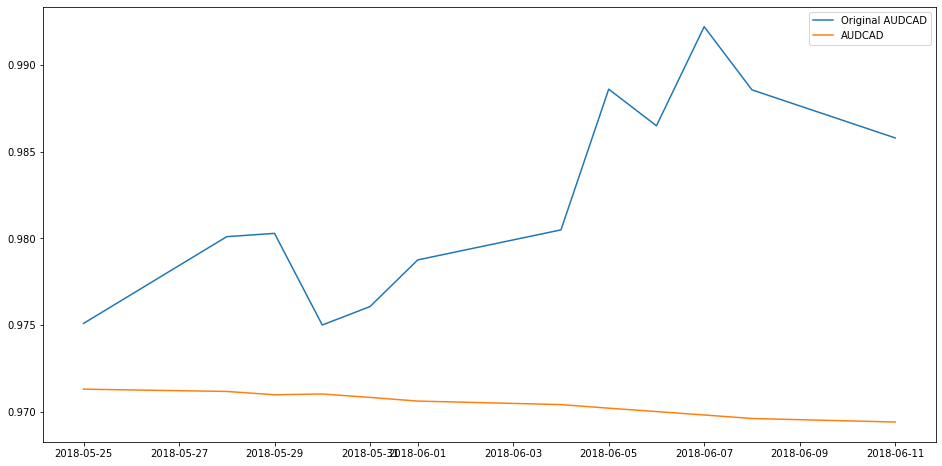

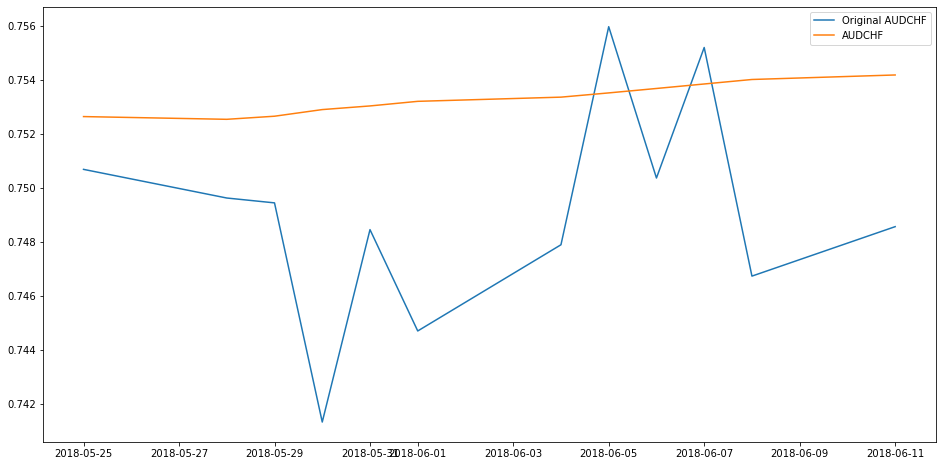

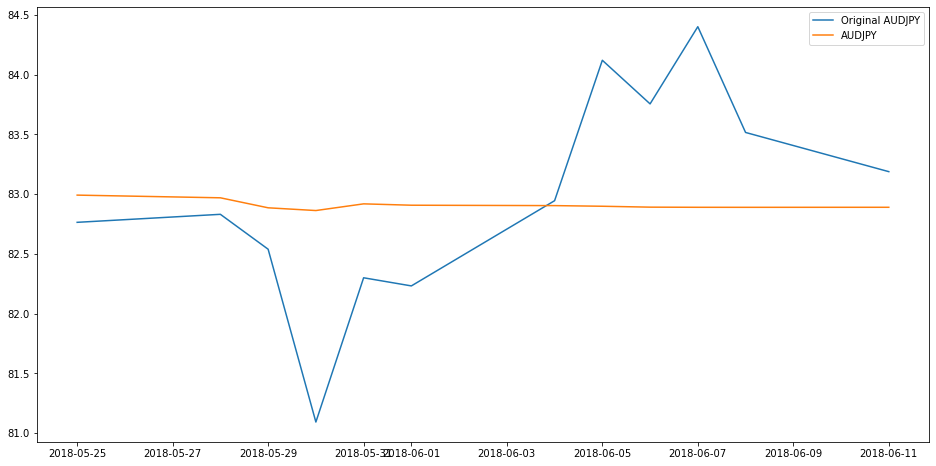

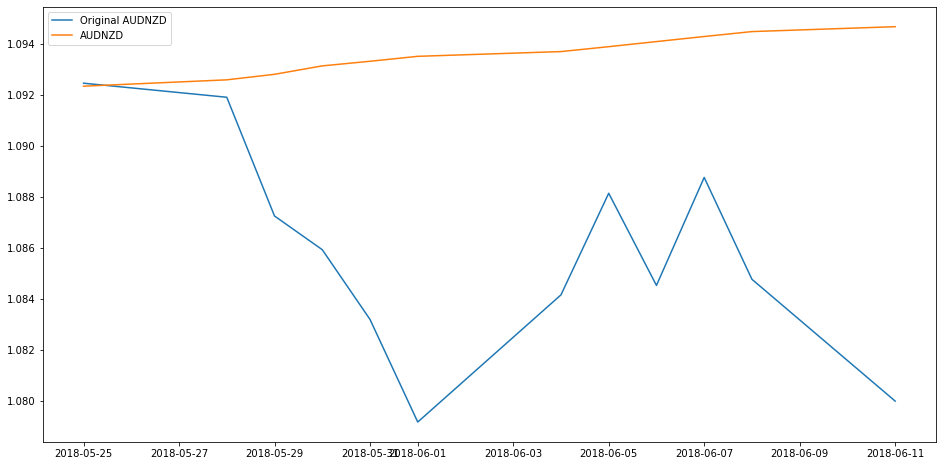

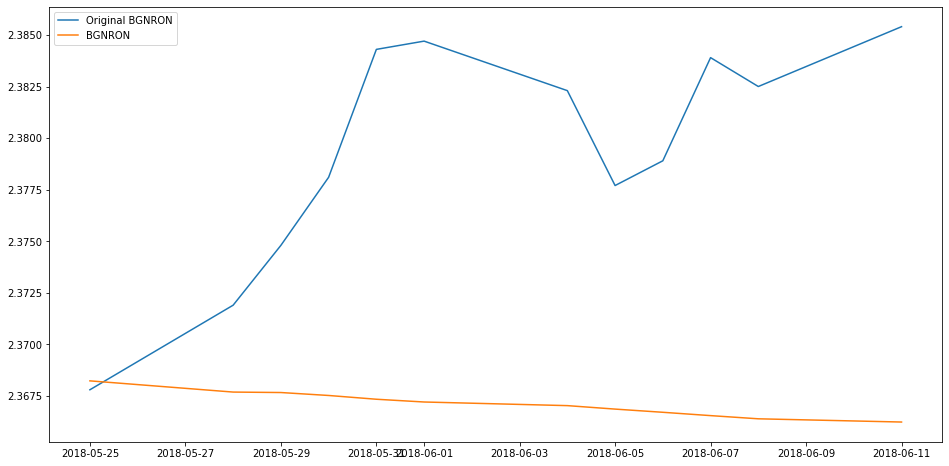

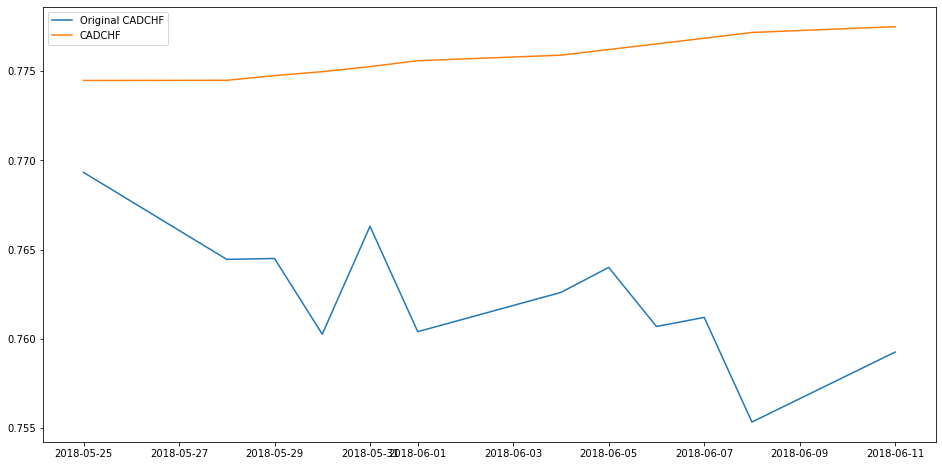

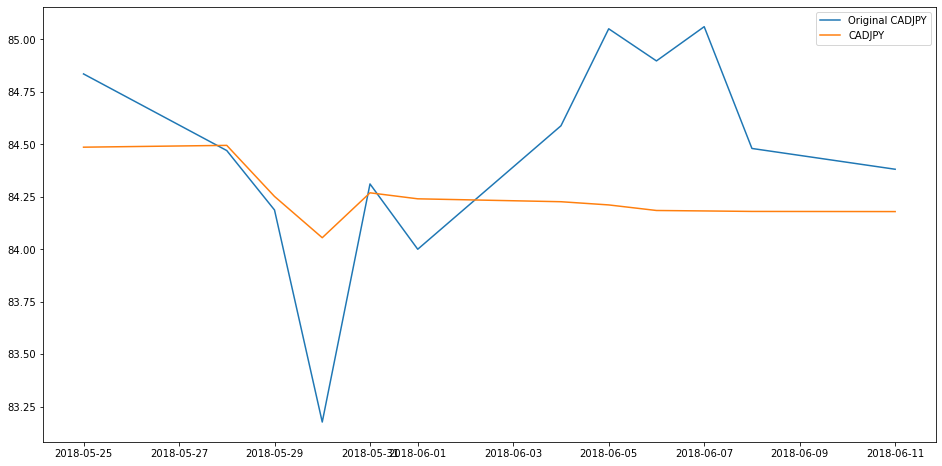

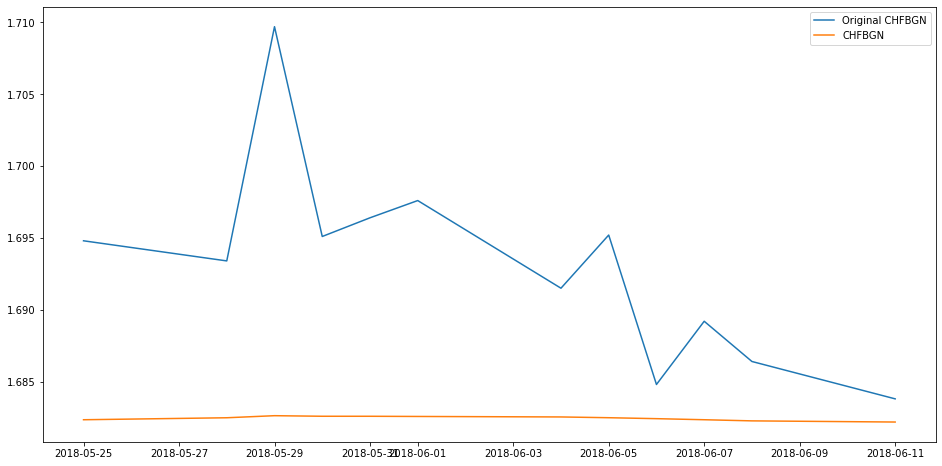

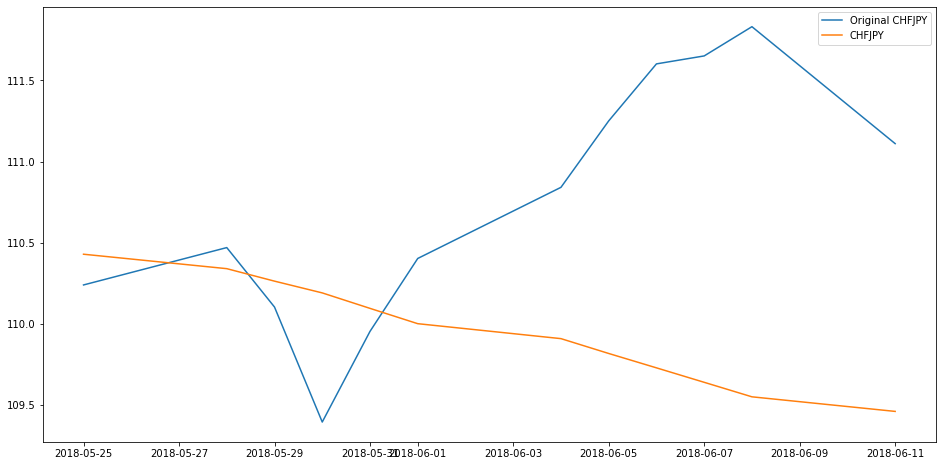

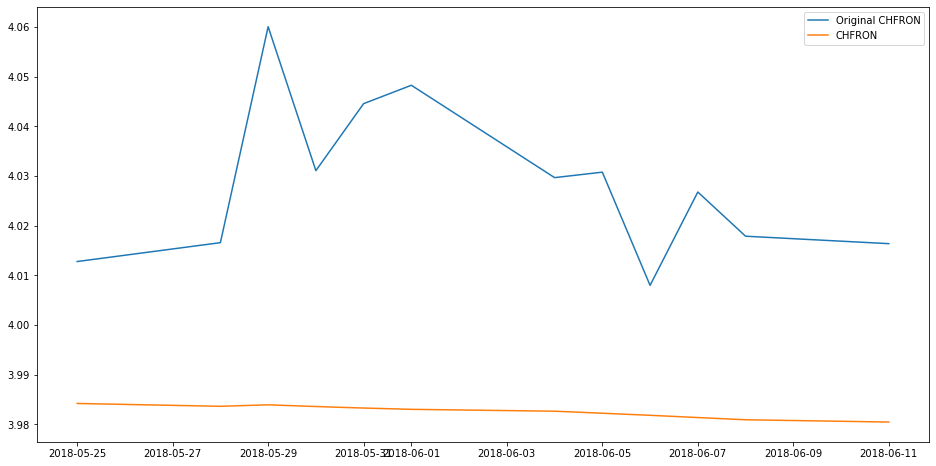

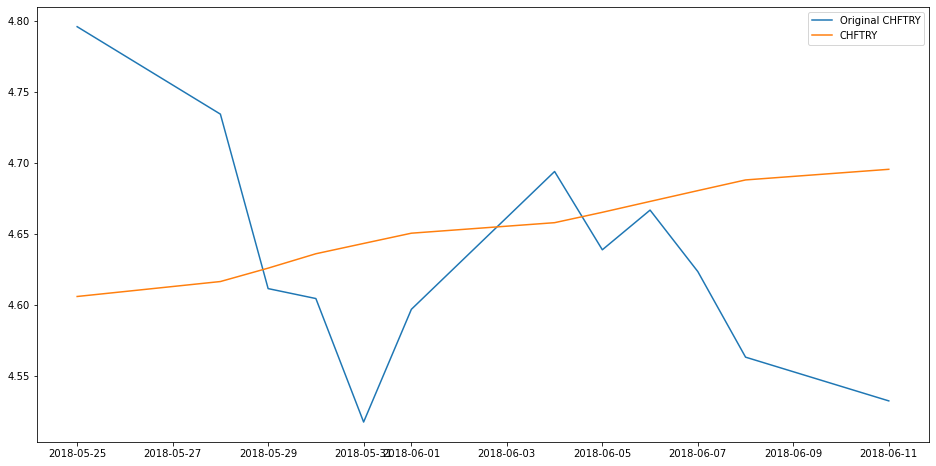

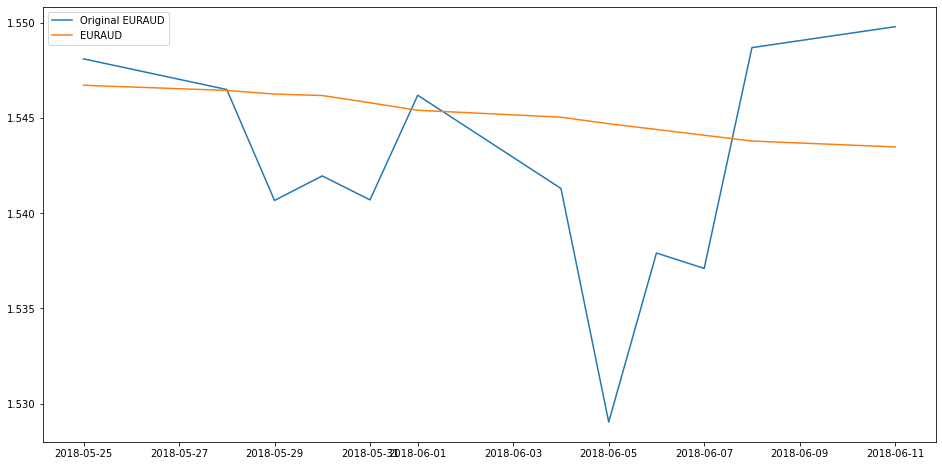

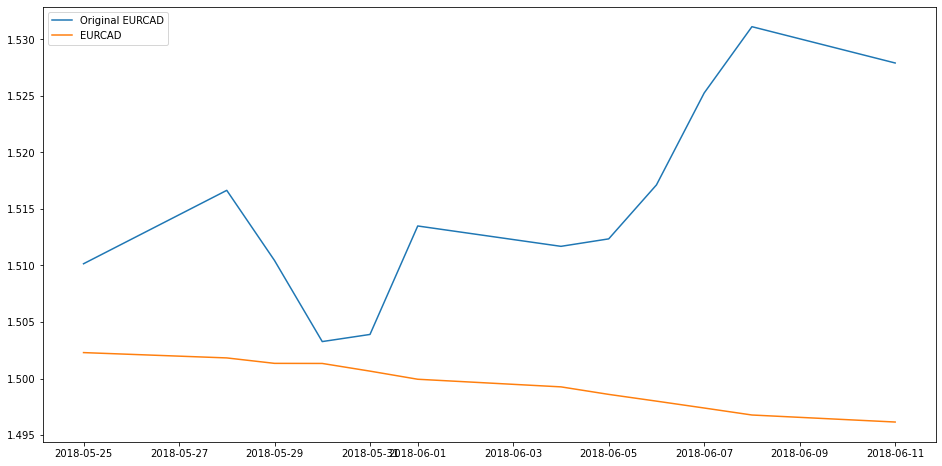

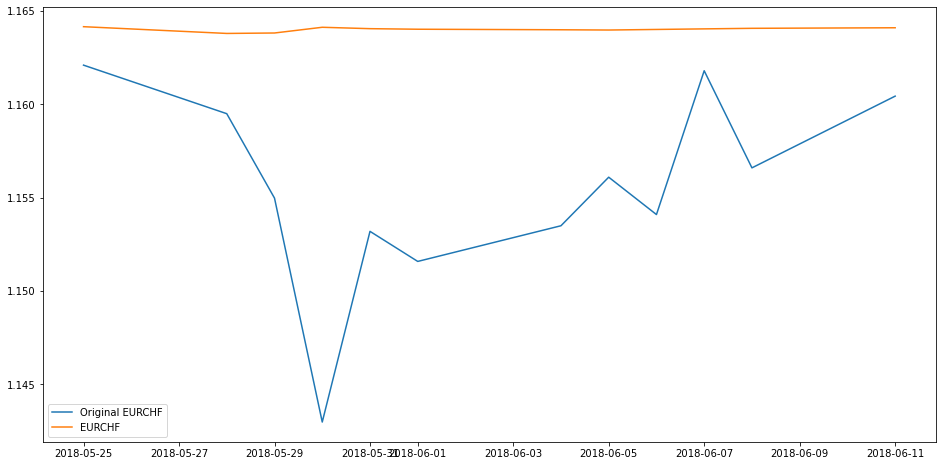

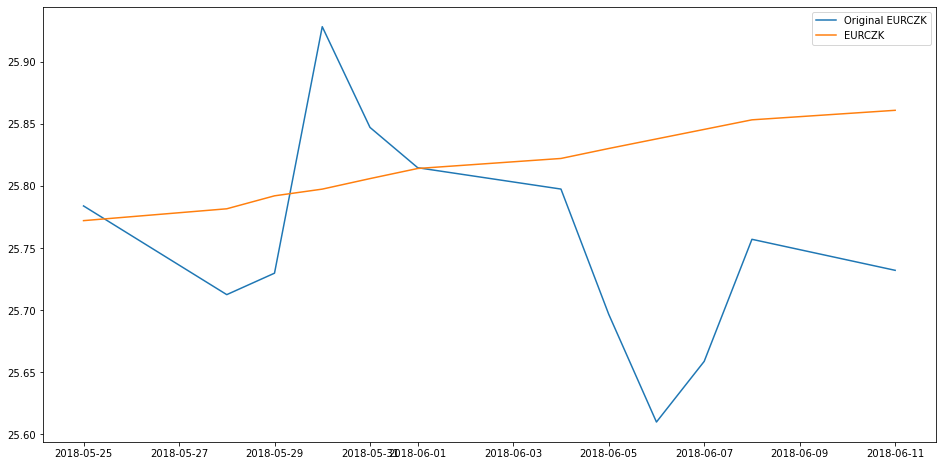

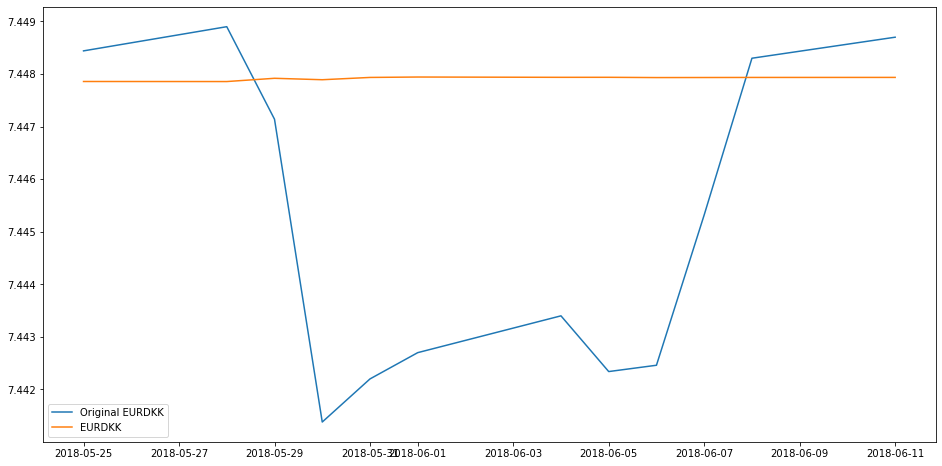

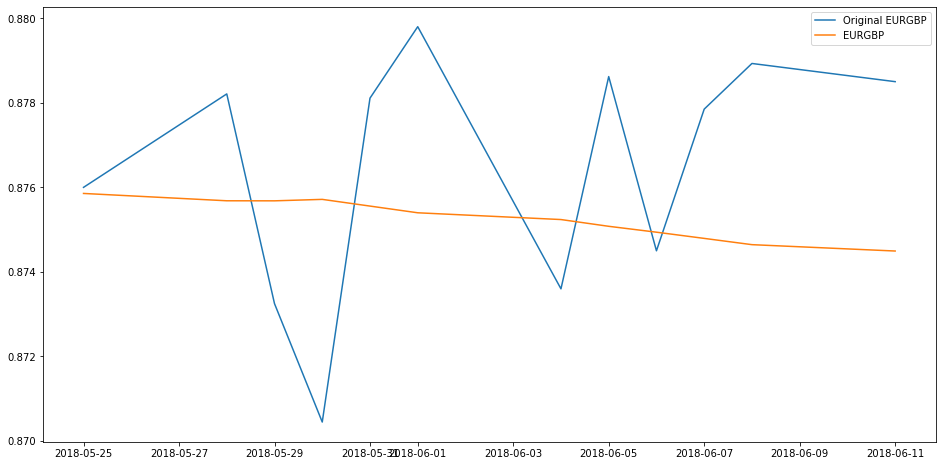

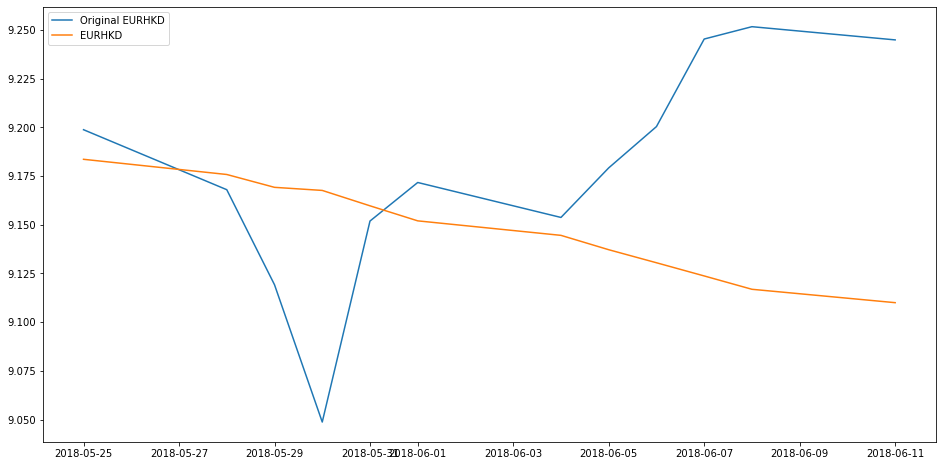

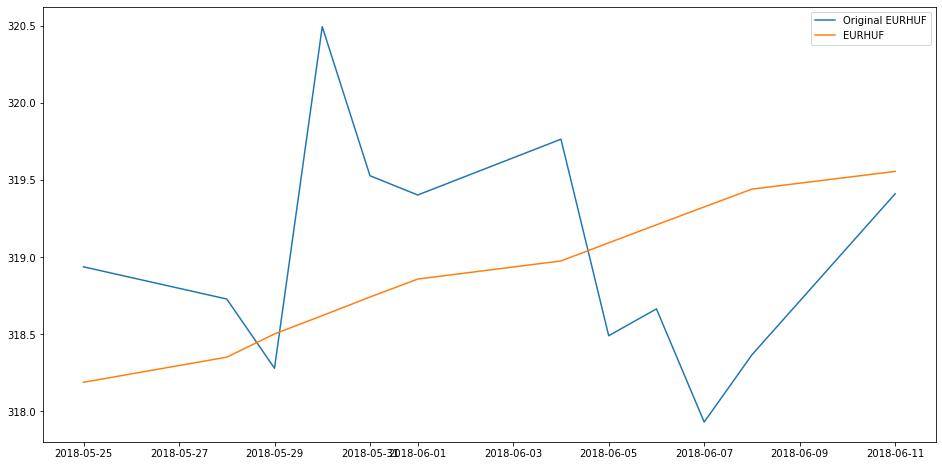

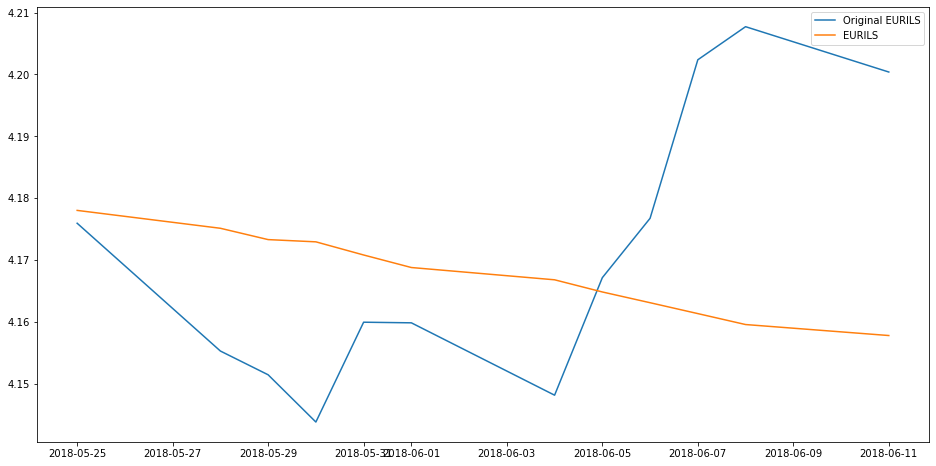

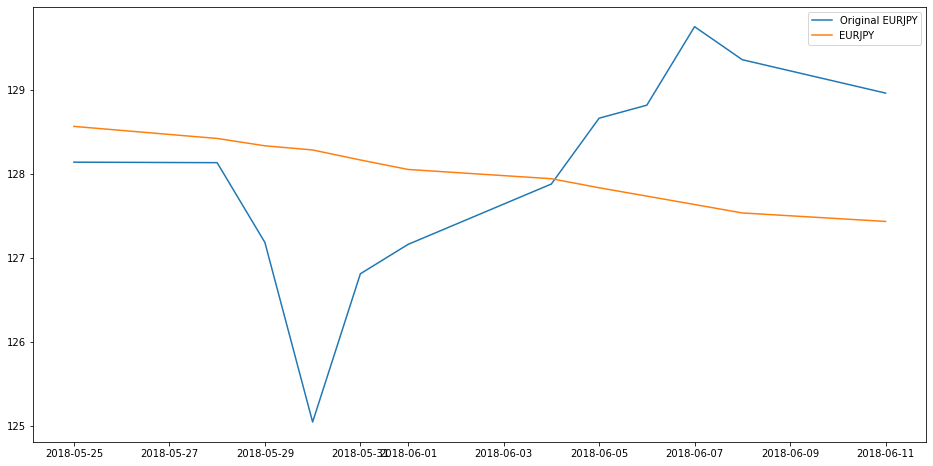

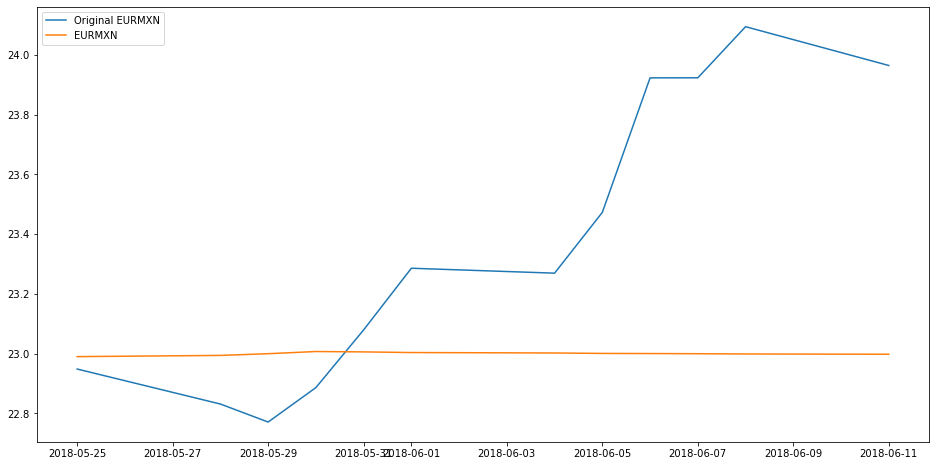

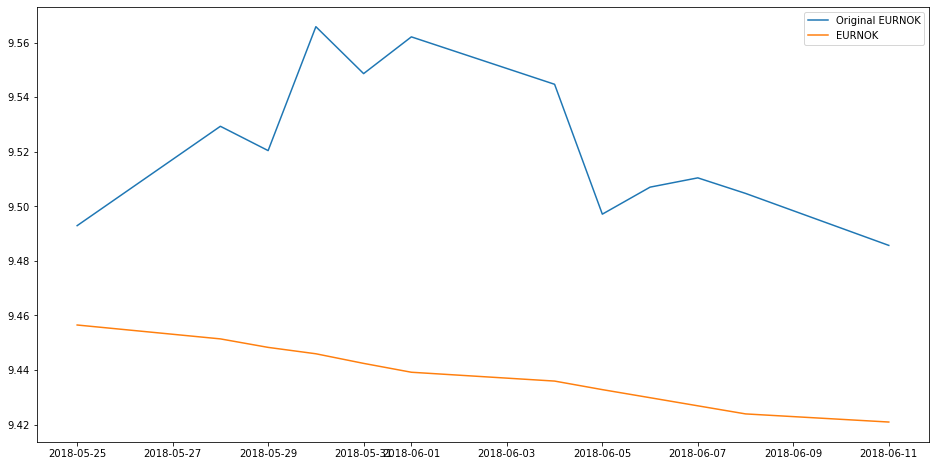

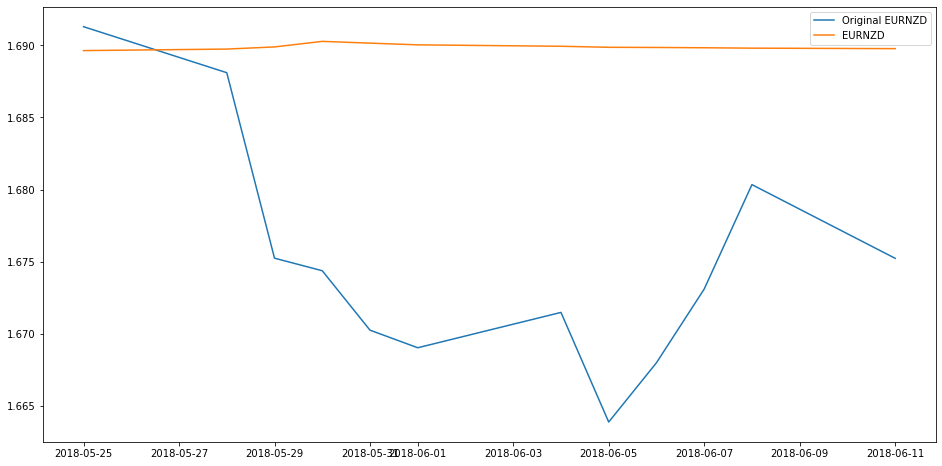

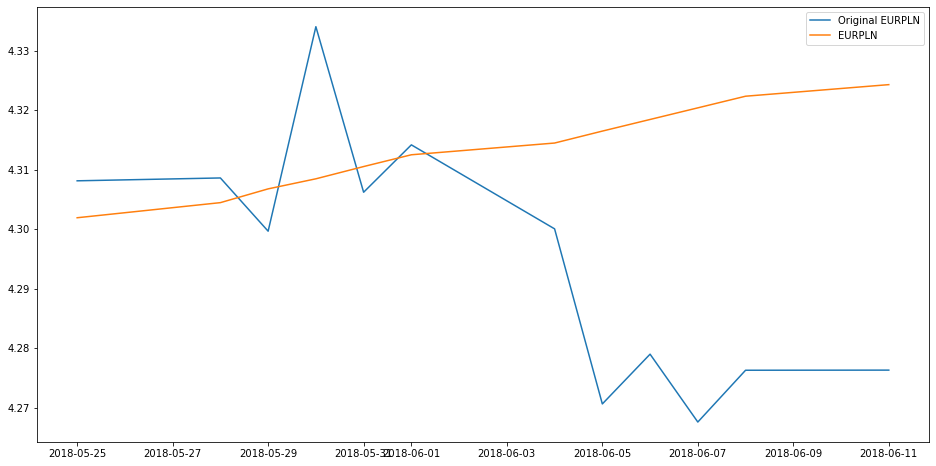

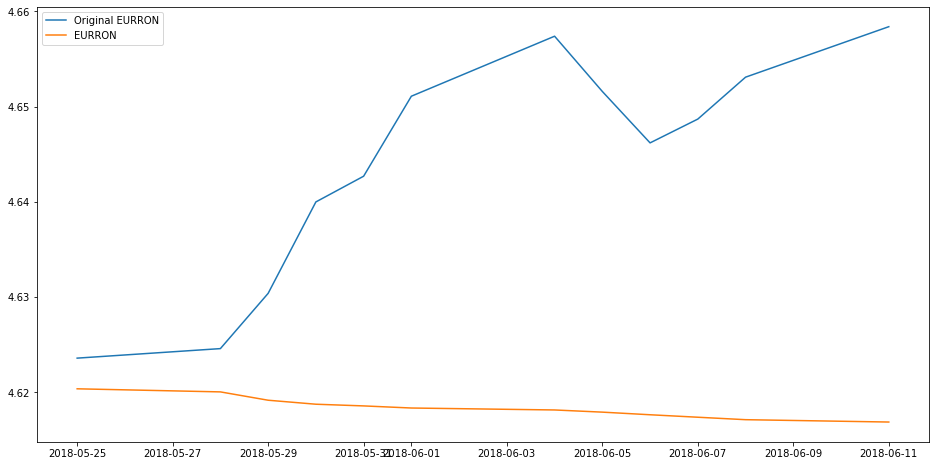

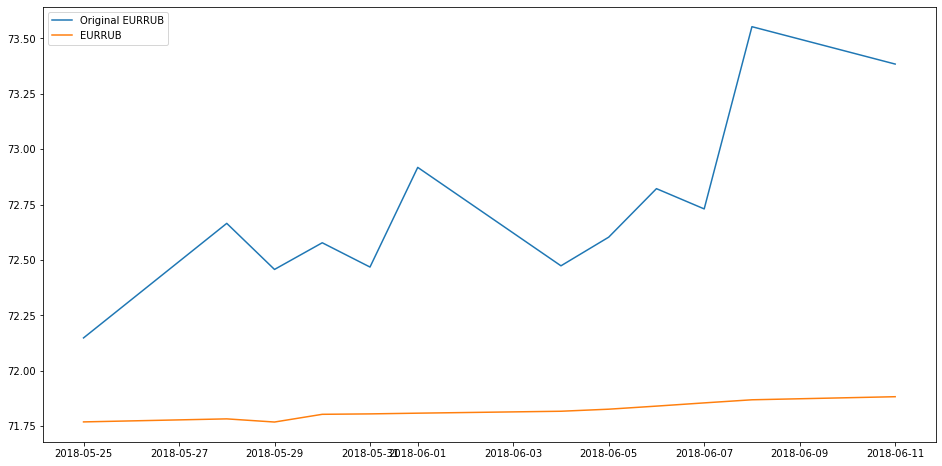

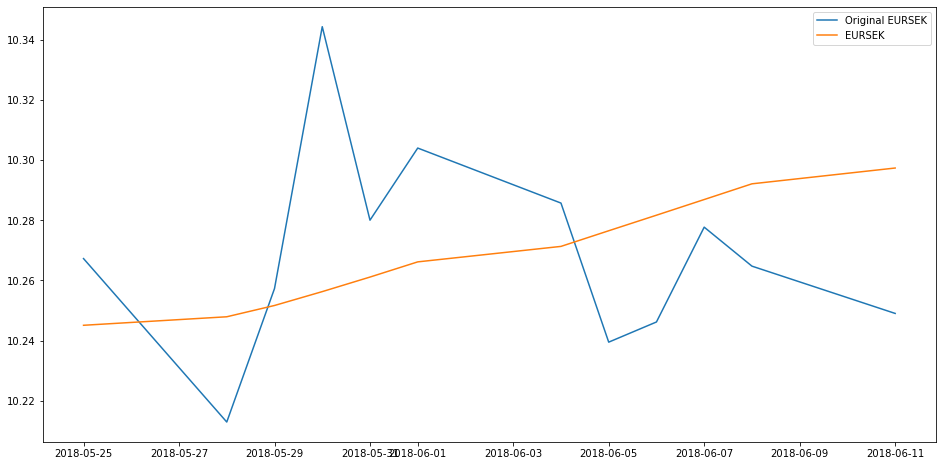

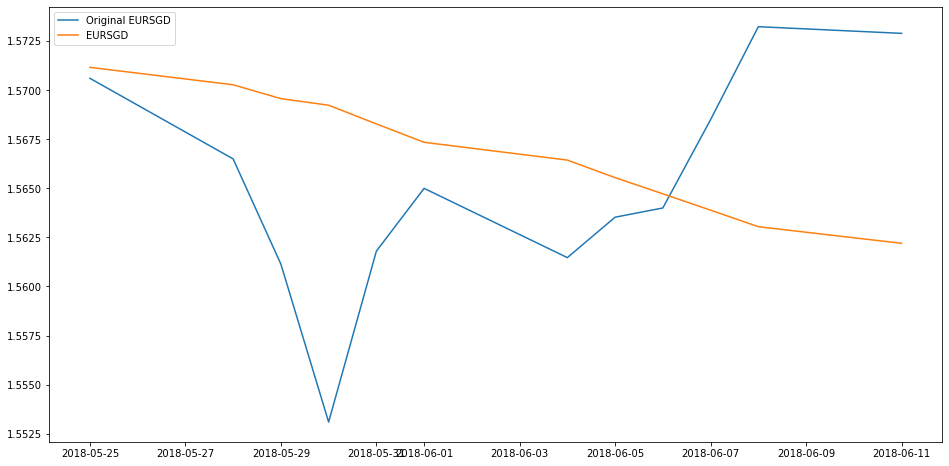

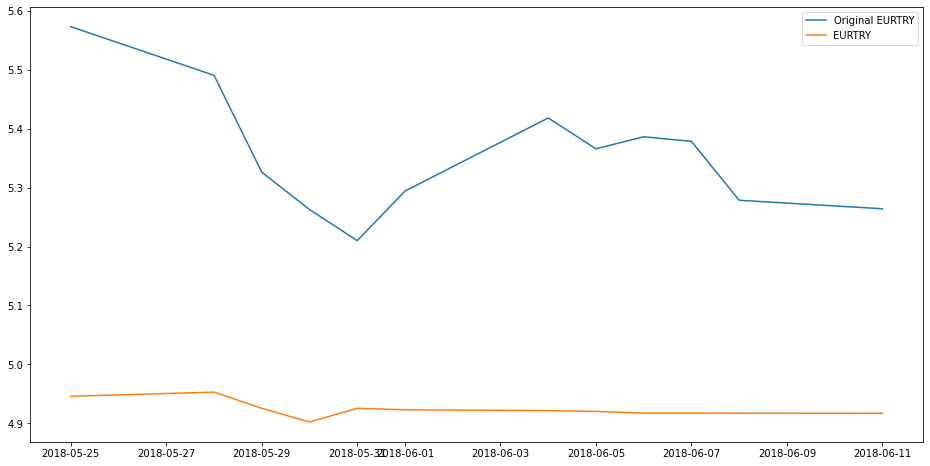

In [23]:
#Plotting values
#fig, ax = plt.subplots(np.shape(Y)[1],1,figsize=(16,8))
#plt.subplots(figsize=(16,4))

for i in range(0,np.shape(Y)[1]):
    
    
    predicted_values = Y_f_BMA[:,:,i]
    
    concat_pred = np.append(Y[:,i], predicted_values)
    
    if tcode.iloc[0,i] > 1:
        
        rebuilt = rebuildFirstDiffT(concat_pred, Data.iloc[0,i])

        rebuilt = np.insert(rebuilt,0, Data.iloc[0,i])

        predicted_values = rebuilt[-12:]
    
    #print(real_values.iloc[:,i])
    #print(dates.iloc[-h:], predicted_values.reshape(-1, 1))
    
    plt.figure(figsize=(16,8))
    #Real values
    plt.plot(dates.iloc[-h:], real_values.iloc[:,i], label='Original '+ labels[i])
    #Predicted values
    plt.plot(dates.iloc[-h:], predicted_values.reshape(-1, 1), label=labels[i])
    #Legend location
    plt.legend(loc = 'best')
    
    plt.show()